In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

#filtrado de warnings
warnings.filterwarnings('ignore')

# haciendo los graficos un poco mas bonitos en matplotlib
plt.style.use('default') 
#plt.rcParams['figure.figsize'] = (20, 10)

# seteando tipo de grid en seaborn
sns.set_theme(style='ticks', palette=None, font_scale=.9) 

# elimino la notacion cientifica en los outputs en pandas
pd.options.display.float_format = '{:20,.2f}'.format

In [ ]:
noticias_online_df = pd.read_parquet('/content/drive/MyDrive/TP_Datos_1C2022/train')

# Heatmap y barplot

## Bar plot

In [ ]:
def convertir_a_dias(registro):
  if registro == 2.0:
    return "Lunes"
  
  if registro == 3.0:
    return "Martes"
  
  #Esto es porque la clase mayoritaria es los miércoles
  if (registro == 4.0) or (registro == 0.0):
    return "Miércoles"
  
  if registro == 5.0:
    return "Jueves"
  
  if registro == 6.0:
    return "Viernes"
  
  if registro == 7.0:
    return "Sábado"
  
  if registro == 8.0:
    return "Domingo"
  
def imputar_nulos(data_frame_matriz):
  for fila in data_frame_matriz.index:
    if data_frame_matriz.loc[fila,:].hasnans:
      serie_actual = data_frame_matriz.loc[fila,:] 
      valores_dia = serie_actual.dropna()
      valor_para_rellenar = valores_dia.sum()/len(valores_dia)
      serie_actual.fillna(valor_para_rellenar, inplace=True)

def imputar_nulos_desde(data_frame_matriz_origen, data_frame_matriz_destino, indicador):
  if indicador == 0:
    data_frame_matriz_destino.loc[:,'amusement'] = data_frame_matriz_origen.loc[:,'amusement']
    data_frame_matriz_destino.loc[:,'anger'] = data_frame_matriz_origen.loc[:,'anger']
    data_frame_matriz_destino.loc[:,'annoyance'] = data_frame_matriz_origen.loc[:,'annoyance']
  
  else:
    data_frame_matriz_destino.loc[:,'relief'] = data_frame_matriz_origen.loc[:,'relief']
    data_frame_matriz_destino.loc[:,'sadness'] = data_frame_matriz_origen.loc[:,'sadness']

In [ ]:
serie_lunes = noticias_online_df.weekday_is_monday.map(lambda x: 2.0 if x == 1.0 else x)
serie_martes = noticias_online_df.weekday_is_tuesday.map(lambda x: 3.0 if x == 1.0 else 0.0)
serie_miercoles = noticias_online_df.weekday_is_wednesday.map(lambda x: 4.0 if x == 1.0 else 0.0)
serie_jueves = noticias_online_df.weekday_is_thursday.map(lambda x: 5.0 if x == 1.0 else 0.0)
serie_viernes = noticias_online_df.weekday_is_friday.map(lambda x: 6.0 if x == 1.0 else 0.0)
serie_sabado = noticias_online_df.weekday_is_saturday.map(lambda x: 7.0 if x == 1.0 else 0.0)
serie_domingo = noticias_online_df.weekday_is_sunday.map(lambda x: 8.0 if x == 1.0 else 0.0)
serie_dias = (serie_lunes + serie_martes + serie_miercoles + serie_jueves + serie_viernes + serie_sabado + serie_domingo).map(lambda x: convertir_a_dias(x))
noticias_online_df['dias'] = serie_dias

In [ ]:
mas_destacado = noticias_online_df.surprise2.value_counts().index[1]
noticias_online_df['surprise2'] = noticias_online_df.surprise2.map(lambda x: mas_destacado if x == '' else x)

In [ ]:
noticias_online_df['surprise_0'] = noticias_online_df.surprise2.map(lambda x: x.split(',')[0])
noticias_online_df['surprise_1'] = noticias_online_df.surprise2.map(lambda x: x.split(',')[1])

In [ ]:
emociones_agrupadas_df_0 = noticias_online_df.groupby('surprise_0').agg({'shares':'count'})

In [ ]:
emociones_agrupadas_df_1 = noticias_online_df.groupby('surprise_1').agg({'shares':'count'})

In [ ]:
emociones_df = emociones_agrupadas_df_0 + emociones_agrupadas_df_1
emociones_df['shares'] = emociones_df.shares.map(lambda x: x if pd.isna(x) else x/2)
emociones_df.iloc[:3,0] = emociones_agrupadas_df_0.iloc[:3,0]
emociones_df.iloc[13:,0] = emociones_agrupadas_df_1.iloc[10:,0]

In [ ]:
emociones_ordenadas_df = emociones_df.sort_values('shares', ascending=False)
emociones_ordenadas_df.index = ['Optimismo', 'Asco', 'Amor', 'Diversión', 'Alegría', 'Miedo', 'Decepción',
                                'Alivio', 'Gratitud', 'Tristeza', 'Vergüenza', 'Nerviosismo', 'Enfado', 'Neutral', 'Molestia']

In [ ]:
emociones_ordenadas_df

,shares
Optimismo,"15,763.00"
Asco,"13,764.50"
Amor,"1,823.50"
Diversión,"1,732.00"
Alegría,"1,125.50"
Miedo,714.00
Decepción,553.50
Alivio,509.00
Gratitud,489.50
Tristeza,243.00


Uso un gráfico con escala logaritmica porque si no no se ven los valores que menos registros tienen (y son varios)

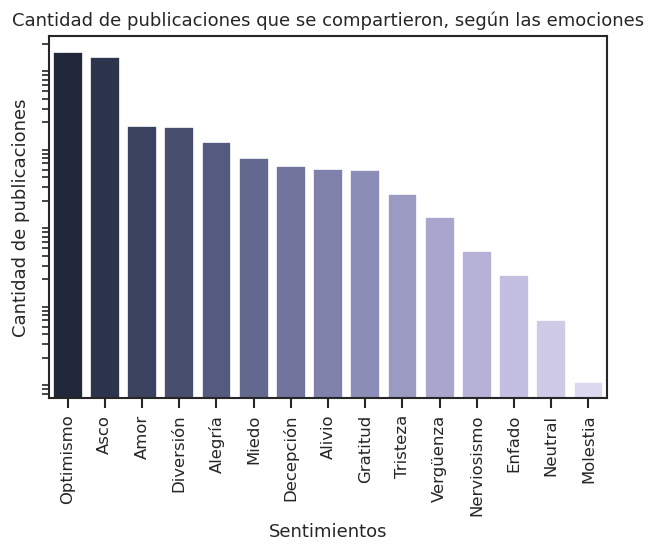

In [ ]:
sns.set_palette(sns.cubehelix_palette(start=2.8, rot=.1, n_colors=15, reverse=True))
ax = sns.barplot(x=emociones_ordenadas_df.index, y=emociones_ordenadas_df.shares)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.title("Cantidad de publicaciones que se compartieron, según las emociones")
plt.ylabel("Cantidad de publicaciones")
plt.xlabel("Sentimientos")
ax.set_yticks([])
plt.show()

## Heatmap

In [ ]:
matriz_sentimientos_0 = pd.pivot_table(noticias_online_df, 
                        values='shares', index='dias', columns='surprise_0', aggfunc='mean')

In [ ]:
matriz_sentimientos_1 = pd.pivot_table(noticias_online_df, 
                        values='shares', index='dias', columns='surprise_1', aggfunc='mean')

In [ ]:
display(matriz_sentimientos_0, matriz_sentimientos_1)

surprise_0,amusement,anger,annoyance,disappointment,disgust,embarrassment,fear,gratitude,joy,love,nervousness,neutral,optimism
dias,,,,,,,,,,,,,
Domingo,"4,376.68","4,000.00",NaN,"3,241.23","3,661.97","1,933.33","3,417.70","5,151.88","4,432.01","4,265.39",NaN,NaN,"3,052.54"
Jueves,"2,924.54","2,833.33",NaN,"2,543.52","3,238.06","1,525.00","3,698.89","4,193.46","3,332.03","3,284.91","1,768.00","1,346.50","2,229.66"
Lunes,"3,398.46","5,650.00",NaN,"2,907.39","3,626.31","1,860.70","3,055.56","3,135.51","3,904.31","5,989.85","1,597.80",NaN,"3,358.34"
Martes,"2,656.39",NaN,NaN,"3,573.10","3,253.73","1,618.00","2,248.22","3,470.80","3,017.46","3,041.15","2,568.33","1,272.00","6,324.57"
Miércoles,"3,069.69","2,611.67","1,400.00","2,264.06","3,446.10","2,192.44","3,414.17","3,298.13","2,767.62","3,584.35","2,161.71","1,233.33","7,610.92"
Sábado,"4,280.78","5,639.60",NaN,"4,380.00","3,908.22","1,266.50","3,080.48","3,802.00","3,695.65","7,776.13","3,580.00","1,350.00","4,172.70"
Viernes,"3,053.24",620.00,NaN,"3,209.63","3,418.67","3,140.00","3,445.68","3,080.50","3,258.20","2,848.19","4,494.70","5,000.00","2,448.34"


surprise_1,disappointment,disgust,embarrassment,fear,gratitude,joy,love,nervousness,neutral,optimism,relief,sadness
dias,,,,,,,,,,,,
Domingo,"3,911.17","4,194.05","4,676.40","3,779.88","1,856.94","4,455.91","4,585.19","6,600.00",NaN,"3,721.93","2,936.10","2,690.53"
Jueves,"2,252.78","2,571.99","3,310.25","2,326.55","3,655.75","3,328.53","3,205.39","4,534.56",NaN,"3,274.39","2,537.84","2,450.88"
Lunes,"3,314.29","3,277.23","2,679.03","3,531.41","2,796.18","2,571.91","3,992.29","4,022.14",726.00,"3,776.07","3,383.68","3,255.84"
Martes,"4,963.07","3,562.00","2,684.04","2,882.83","3,684.29","2,626.84","3,363.45","4,826.18",NaN,"3,162.68","6,403.58","3,780.46"
Miércoles,"2,644.93","2,566.03","2,212.06","3,112.74","2,542.54","3,606.86","2,571.87","3,444.90",NaN,"3,443.41","7,073.72","2,682.60"
Sábado,"1,450.00","4,246.79","3,605.67","5,121.08","2,238.83","7,932.52","3,019.31","1,179.50",NaN,"4,138.02","4,086.91","2,653.85"
Viernes,"1,651.20","3,377.03","4,248.32","2,243.95","4,173.53","2,249.95","3,286.64","2,677.78",910.00,"3,365.11","2,511.20","4,552.40"


In [ ]:
imputar_nulos(matriz_sentimientos_0)
imputar_nulos(matriz_sentimientos_1)

In [ ]:
display(matriz_sentimientos_0, matriz_sentimientos_1)

surprise_0,amusement,anger,annoyance,disappointment,disgust,embarrassment,fear,gratitude,joy,love,nervousness,neutral,optimism
dias,,,,,,,,,,,,,
Domingo,"4,376.68","4,000.00","3,753.27","3,241.23","3,661.97","1,933.33","3,417.70","5,151.88","4,432.01","4,265.39","3,753.27","3,753.27","3,052.54"
Jueves,"2,924.54","2,833.33","2,743.16","2,543.52","3,238.06","1,525.00","3,698.89","4,193.46","3,332.03","3,284.91","1,768.00","1,346.50","2,229.66"
Lunes,"3,398.46","5,650.00","3,498.57","2,907.39","3,626.31","1,860.70","3,055.56","3,135.51","3,904.31","5,989.85","1,597.80","3,498.57","3,358.34"
Martes,"2,656.39","3,003.98","3,003.98","3,573.10","3,253.73","1,618.00","2,248.22","3,470.80","3,017.46","3,041.15","2,568.33","1,272.00","6,324.57"
Miércoles,"3,069.69","2,611.67","1,400.00","2,264.06","3,446.10","2,192.44","3,414.17","3,298.13","2,767.62","3,584.35","2,161.71","1,233.33","7,610.92"
Sábado,"4,280.78","5,639.60","3,911.00","4,380.00","3,908.22","1,266.50","3,080.48","3,802.00","3,695.65","7,776.13","3,580.00","1,350.00","4,172.70"
Viernes,"3,053.24",620.00,"3,168.10","3,209.63","3,418.67","3,140.00","3,445.68","3,080.50","3,258.20","2,848.19","4,494.70","5,000.00","2,448.34"


surprise_1,disappointment,disgust,embarrassment,fear,gratitude,joy,love,nervousness,neutral,optimism,relief,sadness
dias,,,,,,,,,,,,
Domingo,"3,911.17","4,194.05","4,676.40","3,779.88","1,856.94","4,455.91","4,585.19","6,600.00","3,946.19","3,721.93","2,936.10","2,690.53"
Jueves,"2,252.78","2,571.99","3,310.25","2,326.55","3,655.75","3,328.53","3,205.39","4,534.56","3,040.81","3,274.39","2,537.84","2,450.88"
Lunes,"3,314.29","3,277.23","2,679.03","3,531.41","2,796.18","2,571.91","3,992.29","4,022.14",726.00,"3,776.07","3,383.68","3,255.84"
Martes,"4,963.07","3,562.00","2,684.04","2,882.83","3,684.29","2,626.84","3,363.45","4,826.18","3,812.67","3,162.68","6,403.58","3,780.46"
Miércoles,"2,644.93","2,566.03","2,212.06","3,112.74","2,542.54","3,606.86","2,571.87","3,444.90","3,263.79","3,443.41","7,073.72","2,682.60"
Sábado,"1,450.00","4,246.79","3,605.67","5,121.08","2,238.83","7,932.52","3,019.31","1,179.50","3,606.59","4,138.02","4,086.91","2,653.85"
Viernes,"1,651.20","3,377.03","4,248.32","2,243.95","4,173.53","2,249.95","3,286.64","2,677.78",910.00,"3,365.11","2,511.20","4,552.40"


In [ ]:
matriz_sentimientos = (matriz_sentimientos_0 + matriz_sentimientos_1)/2
matriz_sentimientos

,amusement,anger,annoyance,disappointment,disgust,embarrassment,fear,gratitude,joy,love,nervousness,neutral,optimism,relief,sadness
dias,,,,,,,,,,,,,,,
Domingo,NaN,NaN,NaN,"3,576.20","3,928.01","3,304.87","3,598.79","3,504.41","4,443.96","4,425.29","5,176.64","3,849.73","3,387.23",NaN,NaN
Jueves,NaN,NaN,NaN,"2,398.15","2,905.03","2,417.62","3,012.72","3,924.60","3,330.28","3,245.15","3,151.28","2,193.65","2,752.03",NaN,NaN
Lunes,NaN,NaN,NaN,"3,110.84","3,451.77","2,269.86","3,293.48","2,965.84","3,238.11","4,991.07","2,809.97","2,112.28","3,567.21",NaN,NaN
Martes,NaN,NaN,NaN,"4,268.08","3,407.87","2,151.02","2,565.52","3,577.55","2,822.15","3,202.30","3,697.26","2,542.34","4,743.62",NaN,NaN
Miércoles,NaN,NaN,NaN,"2,454.49","3,006.06","2,202.25","3,263.46","2,920.34","3,187.24","3,078.11","2,803.31","2,248.56","5,527.16",NaN,NaN
Sábado,NaN,NaN,NaN,"2,915.00","4,077.50","2,436.08","4,100.78","3,020.42","5,814.08","5,397.72","2,379.75","2,478.29","4,155.36",NaN,NaN
Viernes,NaN,NaN,NaN,"2,430.41","3,397.85","3,694.16","2,844.82","3,627.02","2,754.07","3,067.42","3,586.24","2,955.00","2,906.72",NaN,NaN


In [ ]:
imputar_nulos_desde(matriz_sentimientos_0, matriz_sentimientos, 0)
imputar_nulos_desde(matriz_sentimientos_1, matriz_sentimientos, 1)

In [ ]:
matriz_sentimientos.columns = ['Diversión', 'Enfado', 'Molestia', 'Decepción', 'Asco', 'Vergüenza', 'Miedo', 'Gratitud',  
                                 'Alegría', 'Amor', 'Nerviosismo', 'Neutral', 'Optimismo', 'Alivio', 'Tristeza']
matriz_sentimientos

,Diversión,Enfado,Molestia,Decepción,Asco,Vergüenza,Miedo,Gratitud,Alegría,Amor,Nerviosismo,Neutral,Optimismo,Alivio,Tristeza
dias,,,,,,,,,,,,,,,
Domingo,"4,376.68","4,000.00","3,753.27","3,576.20","3,928.01","3,304.87","3,598.79","3,504.41","4,443.96","4,425.29","5,176.64","3,849.73","3,387.23","2,936.10","2,690.53"
Jueves,"2,924.54","2,833.33","2,743.16","2,398.15","2,905.03","2,417.62","3,012.72","3,924.60","3,330.28","3,245.15","3,151.28","2,193.65","2,752.03","2,537.84","2,450.88"
Lunes,"3,398.46","5,650.00","3,498.57","3,110.84","3,451.77","2,269.86","3,293.48","2,965.84","3,238.11","4,991.07","2,809.97","2,112.28","3,567.21","3,383.68","3,255.84"
Martes,"2,656.39","3,003.98","3,003.98","4,268.08","3,407.87","2,151.02","2,565.52","3,577.55","2,822.15","3,202.30","3,697.26","2,542.34","4,743.62","6,403.58","3,780.46"
Miércoles,"3,069.69","2,611.67","1,400.00","2,454.49","3,006.06","2,202.25","3,263.46","2,920.34","3,187.24","3,078.11","2,803.31","2,248.56","5,527.16","7,073.72","2,682.60"
Sábado,"4,280.78","5,639.60","3,911.00","2,915.00","4,077.50","2,436.08","4,100.78","3,020.42","5,814.08","5,397.72","2,379.75","2,478.29","4,155.36","4,086.91","2,653.85"
Viernes,"3,053.24",620.00,"3,168.10","2,430.41","3,397.85","3,694.16","2,844.82","3,627.02","2,754.07","3,067.42","3,586.24","2,955.00","2,906.72","2,511.20","4,552.40"


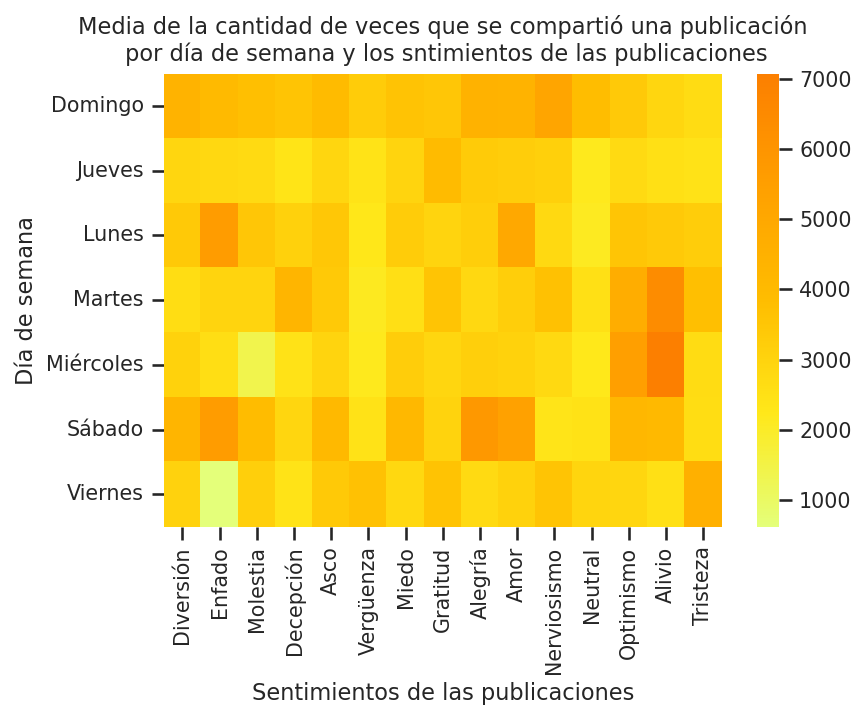

In [ ]:
plt.figure(dpi=150)
sns.heatmap(matriz_sentimientos, cmap='Wistia')
plt.title("Media de la cantidad de veces que se compartió una publicación\n por día de semana y los sntimientos de las publicaciones")
plt.ylabel("Día de semana")
plt.xlabel("Sentimientos de las publicaciones")
plt.show()

# Boxplot

El '< 15000' es porque si no no se ven las cajas correctamente

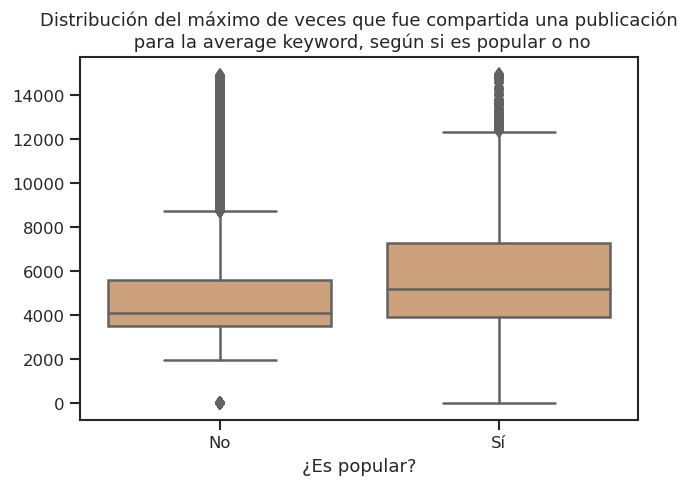

In [ ]:
sns.boxplot(data=noticias_online_df[noticias_online_df['kw_max_avg'] < 15000], x='popular', y='kw_max_avg', color='#DAA06D')
plt.title("Distribución del máximo de veces que fue compartida una publicación\n para la average keyword, según si es popular o no")
plt.xticks(range(2), ['No', 'Sí'])
plt.ylabel("")
plt.xlabel("¿Es popular?")
plt.show()

# Violin plot 

El '< 12000' es porque si no no se ven los violines correctamente

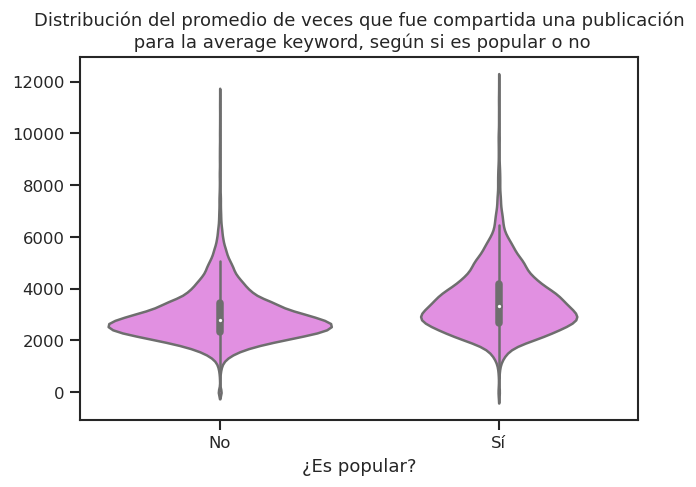

In [ ]:
sns.violinplot(data=noticias_online_df[noticias_online_df['kw_avg_avg'] < 12000], x='popular', y='kw_avg_avg', color='violet')
plt.title("Distribución del promedio de veces que fue compartida una publicación\n para la average keyword, según si es popular o no")
plt.xticks(range(2), ['No', 'Sí'])
plt.ylabel("")
plt.xlabel("¿Es popular?")
plt.show()

# Bar plot y box plot

## Box plot

In [ ]:
serie_estilo_vida = noticias_online_df.data_channel_is_lifestyle.map(lambda x: 2.0 if x == 1.0 else x)
serie_entretenimiento = noticias_online_df.data_channel_is_entertainment.map(lambda x: 3.0 if x == 1.0 else 0.0)
serie_negocios = noticias_online_df.data_channel_is_bus.map(lambda x: 4.0 if x == 1.0 else 0.0)
serie_redes_sociales = noticias_online_df.data_channel_is_socmed.map(lambda x: 5.0 if x == 1.0 else 0.0)
serie_tecnologia = noticias_online_df.data_channel_is_tech.map(lambda x: 6.0 if x == 1.0 else 0.0)
serie_mundo = noticias_online_df.data_channel_is_world.map(lambda x: 7.0 if x == 1.0 else 0.0)
noticias_online_df['canales'] = serie_estilo_vida + serie_entretenimiento + serie_negocios + serie_redes_sociales + serie_tecnologia + serie_mundo

El '< 7000' es porque si no no se ven las cajas correctamente

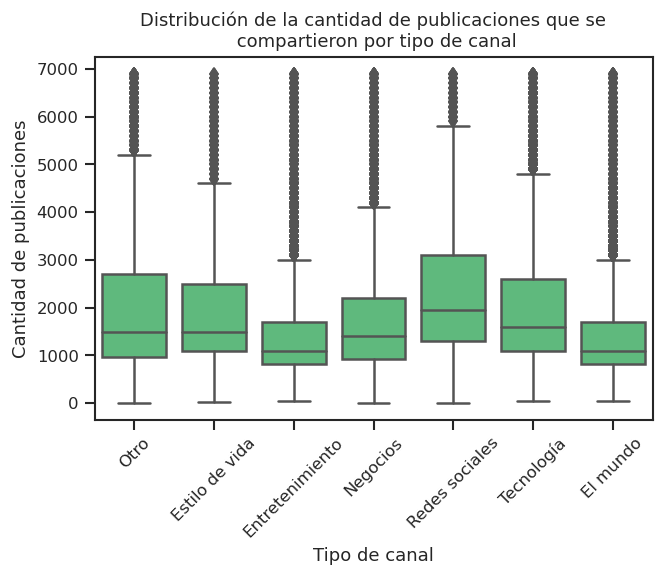

In [ ]:
plt.rcParams['figure.dpi'] = 120
sns.boxplot(data=noticias_online_df[noticias_online_df['shares'] < 7000], x='canales', y='shares', color='#50C878')
labels = ["Otro", "Estilo de vida", "Entretenimiento", "Negocios", "Redes sociales", "Tecnología", "El mundo"]
plt.xticks(range(len(labels)), labels, rotation=45)
plt.title("Distribución de la cantidad de publicaciones que se\n compartieron por tipo de canal")
plt.ylabel("Cantidad de publicaciones")
plt.xlabel("Tipo de canal")


plt.show()

## Bar plot

In [ ]:
canales_agrupados_df = noticias_online_df.groupby('canales').agg({'shares':'count'})

In [ ]:
canales_agrupados_ordenados_df = canales_agrupados_df.sort_values('shares', ascending=False)

In [ ]:
canales_agrupados_ordenados_df.index = ["El mundo", "Tecnología", "Entretenimiento", "Negocios", "Sin datos", "Redes sociales", "Estilo de vida"]

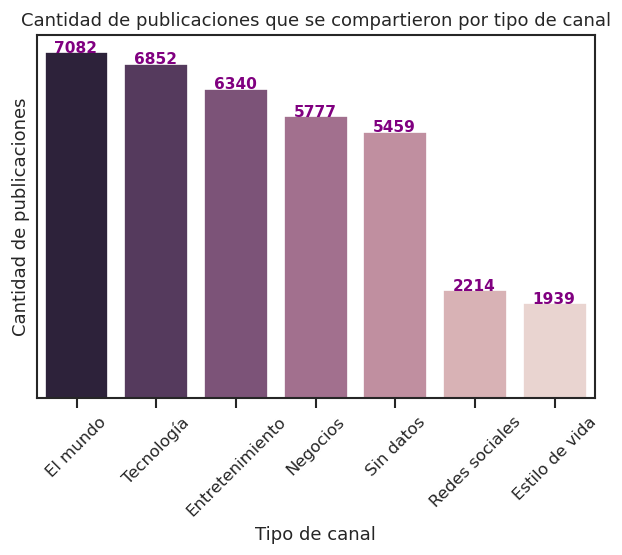

In [ ]:
sns.set_palette(sns.cubehelix_palette(n_colors=7, reverse=True))
ax = sns.barplot(x=canales_agrupados_ordenados_df.index, y=canales_agrupados_ordenados_df.shares)
plt.xticks(rotation=45)
plt.title("Cantidad de publicaciones que se compartieron por tipo de canal")
plt.ylabel("Cantidad de publicaciones")
plt.xlabel("Tipo de canal")
plt.yticks([])

for i, v in enumerate(list(canales_agrupados_ordenados_df.shares)):
    un_decimal = round(v, 1)
    miles = un_decimal*1e-3
    ax.text(i-0.28, v, v, color='purple', fontweight='bold', fontsize=9.2)

plt.show()